In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cirq
from cirq.contrib.svg import SVGCircuit
import random as rd
from sympy import *
import tensorflow as tf
import tensorflow_quantum as tfq
import math
import re
import itertools
from numpy import linalg as LA
from scipy.stats import poisson
import time
from random import choices
from random import  uniform

2023-03-22 15:09:51.438445: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 15:09:51.438459: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 15:09:52.141474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-22 15:09:52.141487: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-22 15:09:52.141497: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (rafael-ThinkPad): /proc/driver/nvidia/version does not exist
2023-03-22 15:09:52.141639: I tensorflow/core/platform/cpu_fe

In [2]:
k = 3 #length of clauses
n_var = 6 #number of variables
nqubits = n_var #number of qubits in the circuit
all_vars = [i for i in range(-n_var,n_var+1)]
all_vars = [i for i in all_vars if i != 0]

In [3]:
r_by_k = {2 : 1, 3: 6.43, 4: 20.43, 5 : 45.7, 6: 70.21, 8: 176.54, 10: 708.92, 16: 45425.2}

def generate_instance(k: int, n: int) -> np.ndarray:
    #generate an instance of random k-SAT with n variables in the satisfiability threshold
    if not (r := r_by_k.get(k)):
        raise ValueError(f"k must be in {list(r_by_k)} (got {k})")
    m = poisson(r*n).rvs()
    #return np.random.choice(all_vars, size=(m, k))
    all_variables = []
    all_signs = []
    for i in range(m):
        #all_signs.append([rd.choice(l) for i in range(k)])
        all_variables.append(choices(all_vars, k = k))

    all_variables = np.array(all_variables)
    #all_signs = np.array(all_signs)
    return all_variables

In [4]:
def generate_binary_strings(bit_count):
    binary_strings = []
    def genbin(n, bs=''):
        if len(bs) == n:
            binary_strings.append(bs)
        else:
            genbin(n, bs + '0')
            genbin(n, bs + '1')

    genbin(bit_count)
    return binary_strings

binary_strings = generate_binary_strings(nqubits)

In [5]:
def dimacs_writer(dimacs_filename, cnf_array):
    #writes the dimacs file with the CNF
    cnf = cnf_array
    cnf_length = len(cnf)
    n_sat = len(cnf[0])
    var_num = np.max(cnf) 
    with open(dimacs_filename, "w") as f:

        f.write('c DIMACS file CNF '+str(n_sat)+'-SAT \n')
        f.write("p cnf {} {}\n".format(var_num, cnf_length))
        
        for i, clause in enumerate(cnf):
            line = clause.tolist()
            if i == cnf_length - 1:
                s = ' '.join(str(x) for x in line)+' 0'
                f.write(s)
            else: 
                s = ' '.join(str(x) for x in line)+' 0 \n'
                f.write(s)

In [6]:
class Verifier():
    #verifier from Qiskit page, takes a bit string and checks if cnf is satisfied
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [7]:
valid_keys = []
dimacs_filename = "random_cnf_BM.dimacs" 

while not valid_keys:
    #only accepts satisfiable CNFs
    inst = generate_instance(k, n_var)
    dimacs_writer(dimacs_filename, inst)
    v = Verifier('random_cnf_BM.dimacs')
    
    for key in binary_strings:
        if v.is_correct(key) == True:
            print(key) 
            valid_keys.append(key)

100111


In [8]:
with open('random_cnf_BM.dimacs', 'r') as f:
    dimacs = f.read()
#print(dimacs)
unsat_list = []

for key in binary_strings:
    guess = [bool(int(x)) for x in key][::-1]

    clause_eval_list = []
    counter = 0
    for j, line in enumerate(dimacs.split('\n')):

        line = line.strip(' 0')
        clause_eval = False

        for literal in line.split(' '):
            if literal in ['p', 'c']:
                #line is not a clause
                clause_eval = True
                break
            if '-' in literal:
                literal = literal.strip('-')
                lit_eval = not guess[int(literal)-1]
            else:
                lit_eval = guess[int(literal)-1]
            clause_eval |= lit_eval
        #print(clause_eval)
        if j > 1:
            counter += 1
            clause_eval_list.append(clause_eval)
    unsat_clauses = counter - sum(clause_eval_list)
    unsat_list.append(unsat_clauses)

In [9]:
diagonal = unsat_list

In [10]:
#diagonal = [float(i)/sum(unsat_list) for i in unsat_list]

In [11]:
qubits = []

for i in range(nqubits):
    qubits.append(cirq.GridQubit(0,i))        
    
qubits = list(qubits) #don't know why
all_qubits = [i for i in range(nqubits)]

In [12]:
def my_gate(c, index):
    g = c * cirq.Z.on(qubits[index]) + cirq.I.on(qubits[index])
    return g

x = [1, -1]
combinations = [p for p in itertools.product(x, repeat=nqubits)]

ops_list = []
for j, combination in enumerate(combinations):
    ops_list.append((diagonal[j]/2**nqubits)*math.prod([my_gate(combination[i], i) for i in range(nqubits)]))

cost = np.sum(ops_list)
cost.matrix()

array([[5.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 2.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 3.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 7.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 6.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 5.+0.j]])

In [13]:
def ham_layer(diagonal, circuit, qubits, par):
    
    l = cirq.DiagonalGate(diagonal)._decompose_(qubits)
    l.pop(0)
    for j, gate in enumerate(l):

        if j % 2 == 0:
            dictn = gate._json_dict_()
            my_string = str(dictn['gate'])
            my_other_string = str(dictn['qubits'])
            number_p = re.findall("\d+\.\d+", my_string)
            res_p = [eval(i) for i in number_p]
            if '-' in my_string:
                sign = -1
            else:
                sign = 1
            
            number_q = re.findall(r'\d+', my_other_string)
            res_q = [eval(i) for i in number_q]
            kernel = sign*par*res_p[0]*np.pi
            rzgate = cirq.rz(kernel).on(qubits[res_q[1]])
            circuit.append(rzgate)
        else:
            circuit.append(gate)

In [14]:
def mixing_circuit(circuit, qubits, par):
    for i in range(len(qubits)):
        circuit.append(cirq.rx(par).on(qubits[i]))
    return circuit

In [66]:
qaoa_circuit = cirq.Circuit()

p = 4 #number of layers

num_param = 2 * p 
parameters = symbols("q0:%d" % num_param)

#setting up the layers
for i in range(p):
    ham_layer(diagonal, qaoa_circuit, qubits, parameters[2 * i])
    mixing_circuit(qaoa_circuit, qubits, parameters[2 * i + 1])

In [67]:
qaoa_circuit

(0, 0): ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(-0.25*q0)───X───Rz(-0.25*q0)───X───Rz(0)───X───Rz(0.25*q0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q0)───X───Rz(-0.5*q0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q0)───X───Rz(0)────X───Rz(0)───X───Rz(0)───X───Rz(-0.25*q0)───X───Rz(0.75*q0)───X───Rz(-0.25*q0)───X───Rz(0)────X───Rz(0)────Rx(q1)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(-0.25*q2)───X───Rz(-0.25*q2)───X───Rz(0)───X───Rz(0.25*q2)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q2)───X───Rz(-0.5*q2)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q2)───X───Rz(0)────X───Rz(0)───X───Rz(0)───X───Rz(-0.25*q2)───X───Rz(0.75*q2)───X───Rz(-0.25*q2)───X───Rz(0)────X───Rz(0)────Rx(q3)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(-0.25*q4)───X───Rz(-0.25*q4)───X───Rz(0)───X───Rz(0.25*q4)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q4)───X───Rz(-0.5*q4)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q4)───X───Rz(0)────X───Rz(0)───X───Rz(0)───X───Rz(-0.25*q4)───X───Rz(0.75*q4)───X───Rz(-0.25*q4)───X───Rz(0)────X───Rz(0)────Rx(q5)────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X───Rz(-0.25*q6)───X───Rz(-0.25*q6)───X───Rz(0)───X───Rz(0.25*q6)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q6)───X───Rz(-0.5*q6)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0)───X───Rz(0.25*q6)───X───Rz(0)────X───Rz(0)───X───Rz(0)───X───Rz(-0.25*q6)───X───Rz(0.75*q6)───X───Rz(-0.25*q6)───X───Rz(0)────X───Rz(0)────Rx(q7)───
                                                                                                                                                                                                                                                                                               

In [68]:
class MyLRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        return self.initial_learning_rate / (step+1)

In [69]:
initial = cirq.Circuit()

for qubit in qubits:
    initial.append(cirq.H(qubit)) #applying Hadamard to all qubits before running circuit

#setting up the model
lr = 1e-1

inputs = tfq.convert_to_tensor([initial])
ins = tf.keras.layers.Input(shape = (), dtype = tf.dtypes.string)
outs = tfq.layers.PQC(qaoa_circuit, cost)(ins)
ksat = tf.keras.models.Model(inputs = ins, outputs = outs)
opt = tf.keras.optimizers.Adam(learning_rate = 0.01)

all_pars = []
for i in range(2*p):
    if i % 2 == 0:
        par = -0.01
    else:
        par = 0.01
    all_pars.append(par)

ksat.trainable_variables[0].assign(all_pars) #initializing angles with some small noise

<tf.Variable 'UnreadVariable' shape=(8,) dtype=float32, numpy=
array([-0.01,  0.01, -0.01,  0.01, -0.01,  0.01, -0.01,  0.01],
      dtype=float32)>

In [70]:
initial_parameters = []

for i in range(p):
    if i % 2 == 0:
        p1, p2 = rd.uniform(-2*np.pi, 2*np.pi), rd.uniform(-2*np.pi, 2*np.pi)    
        p1, p2 = p1, p2
    else:
        p1, p2 = -p1, -p2
    initial_parameters.append((p1, p2))

#ksat.trainable_variables[0].assign(np.array(flatten(initial_parameters))) #initializing angles with some small noise

In [71]:
cost_m = cost.matrix()
gs_energy = np.real(min(LA.eig(cost_m)[0]))
gs_energy

0.0

In [72]:
losses = []
error = 1e2*rd.random()
tol = 1e-2

start = time.time()

j=0
while j < 1e4:
    previous_error = error   
    with tf.GradientTape() as tape:
        error = ksat(inputs)
    
    grads = tape.gradient(error, ksat.trainable_variables)
    opt.apply_gradients(zip(grads, ksat.trainable_variables))
    error = error.numpy()[0,0]
    losses.append(error)

    print('absolute value of (ground state energy - error) is ' + str(abs(gs_energy - error)), end = '\r')
   
    if abs(error - previous_error) < 1e-10:
        print('\n got stuck!')
        break
    j += 1
    
end = time.time()

absolute value of (ground state energy - error) is 0.35805097222328186
 got stuck!


In [73]:
print("Time consumed in working: ",end - start)

Time consumed in working:  8.757906913757324


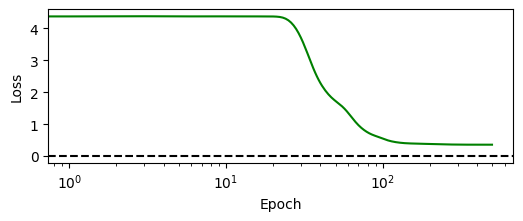

In [74]:
plt.figure(figsize=(6,2))
plt.plot(losses, color = "green")
plt.axhline(y = 0, color = 'black', linestyle = 'dashed')
plt.xscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
#plt.savefig("TSP_losses")

In [75]:
def to_dec(x):
    return int("".join(str(i) for i in x), 2) 

In [76]:
params = ksat.trainable_variables

start = time.time()

sample_circuit = tfq.layers.AddCircuit()(inputs, append=qaoa_circuit)
output = tfq.layers.Sample()(sample_circuit, symbol_names=parameters, symbol_values=params, repetitions = 2048)

end = time.time()

print("Time consumed in sampling: ",end - start)

quantum_preds = []
data = []
for bits in output.values:
    temp = []
    data.append(to_dec(bits.numpy()))
    for pos, bit in enumerate(bits):
        if bit == 1:
            temp.append(pos)
    quantum_preds.append(temp)

Time consumed in sampling:  0.06809711456298828


In [77]:
params

[<tf.Variable 'parameters:0' shape=(8,) dtype=float32, numpy=
 array([0.26444277, 1.2707455 , 0.48907083, 1.0780779 , 0.6799797 ,
        0.7779571 , 0.88588524, 0.39401537], dtype=float32)>]

In [78]:
valid_keys

['100111']

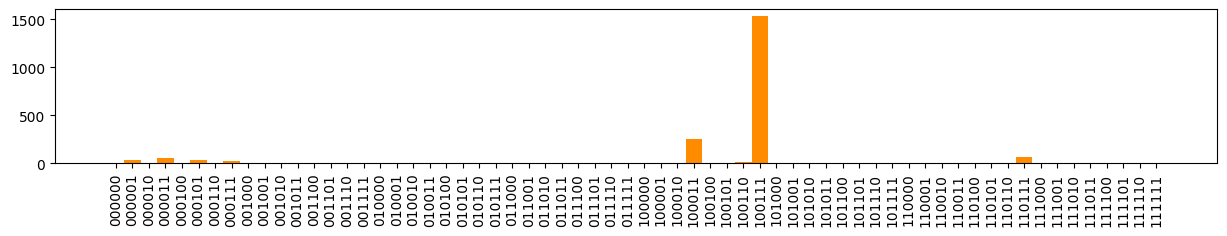

In [79]:
xticks = range(0, 2**nqubits)
xtick_labels = list(map(lambda x: format(x, "0"+str(nqubits)+"b"), xticks))
bins = np.arange(0, 2**nqubits + 1) - 0.5

plt.figure(figsize=(15,2))
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(data, bins=bins, color = "darkorange", lw=0)
#plt.savefig('hist_custom_sat.pdf')
plt.show()